## installing the libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(device[0], True)
except:
    pass

## data loading

In [4]:
import gdown

In [6]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [84]:
def load_vide(path: str) -> List[float]:
    """
    Loads the video from a path string as a list of float number 
    Args: 
        path: string path to video file
    Returns:
        tf.cast((frames - mean), tf.float32) / std: standardised representation of the video
    """

    #reading the frames
    cap = cv2.VideoCapture(path)
    frames = []

    #itterating over the each frames
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
         # read the frame data from the cap object
        ret, frame = cap.read()

        #convert the frame to grayscale
        frame = tf.image.rgb_to_grayscale(frame) 

        #append the frame to the array
        frames.append(frame[190:236, 80:220,:]) #capturing only the region near the lip i.e isolating the lip region
    cap.release()

    #performing the standardization of the dataset
    mean = tf.math.reduce_mean(frames) #calculate the eman of the frames array
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # calcualte the standard deviation of the array

    return tf.cast((frames - mean), tf.float32) / std #retruning a standardised frame

In [85]:
# defining a vacabulary list
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [86]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [88]:
# fucntion to convert characters to numbers and numbers to characters
char_2_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") # if oov-> out of vocabulary encountered, it returns ""
num_2_char = tf.keras.layers.StringLookup(
    vocabulary = char_2_num.get_vocabulary(), oov_token = "", invert = True
)

print(
    f"The vocabulary size is : {char_2_num.get_vocabulary()} "
    f"(size  = {char_2_num.vocabulary_size()})"
)

The vocabulary size is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size  = 40)


In [89]:
char_2_num(['a' ,'b', 'c', 'd'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>

In [90]:
num_2_char([1, 2, 3, 4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [91]:
def load_alignments(path: str) -> List[str]:
    """
    Function to load the allignment data from the path provided
    Args:
        path: path to the allignment file
    Returns: 
        
    """
    with open(path, 'r') as f:
        lines = f.readlines() #read individual line and append it to the list
    tokens = []
    for line in lines: 
        line  = line.split()
        if line[2] !='sil': #if in the paticular region there is no silence
            tokens = [*tokens, ' ', line[2]]
    #return the data after converting the characters to numbers 
    return char_2_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] # 


In [92]:
def load_data(path: str):
    """
    loads the video and the allignment path 
    Args:
        path: path to the video file
    Returns: 
        franes: The array containing the frame data for the video
        alignments: The array containing the data for the anotations 
    """
    path = bytes.decode(path.numpy())

    #extracting the file name, video path, alignment path
    file_name = path.split('\\')[-1].split('.')[0].split('/')[-1]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')

    #getting the franes and alignment using the load_vide and load_alignments function
    frames = load_vide(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [93]:
test_path = "data/s1/bbal6n.mpg"

In [94]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'data/s1/bbal6n.mpg'>

In [95]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4622627 ],
          [ 1.4622627 ],
          [ 1.3832215 ],
          ...,
          [ 0.19760308],
          [ 0.19760308],
          [ 0.07904124]],
 
         [[ 1.4622627 ],
          [ 1.4622627 ],
          [ 1.3832215 ],
          ...,
          [ 0.19760308],
          [ 0.07904124],
          [ 0.03952062]],
 
         [[ 1.4227421 ],
          [ 1.4227421 ],
          [ 1.3832215 ],
          ...,
          [ 0.07904124],
          [ 0.11856185],
          [ 0.11856185]],
 
         ...,
 
         [[ 0.9089742 ],
          [ 0.9089742 ],
          [ 0.9089742 ],
          ...,
          [ 9.959195  ],
          [ 9.919675  ],
          [ 9.919675  ]],
 
         [[ 0.9089742 ],
          [ 0.9089742 ],
          [ 0.9089742 ],
          ...,
          [ 9.880154  ],
          [ 9.880154  ],
          [ 9.880154  ]],
 
         [[ 0.9089742 ],
          [ 0.9089742 ],
          [ 0.9089742 ],
          

In [96]:
frames, alignment = load_data(tf.convert_to_tensor(test_path))

In [97]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4622627 ],
         [ 1.4622627 ],
         [ 1.3832215 ],
         ...,
         [ 0.19760308],
         [ 0.19760308],
         [ 0.07904124]],

        [[ 1.4622627 ],
         [ 1.4622627 ],
         [ 1.3832215 ],
         ...,
         [ 0.19760308],
         [ 0.07904124],
         [ 0.03952062]],

        [[ 1.4227421 ],
         [ 1.4227421 ],
         [ 1.3832215 ],
         ...,
         [ 0.07904124],
         [ 0.11856185],
         [ 0.11856185]],

        ...,

        [[ 0.9089742 ],
         [ 0.9089742 ],
         [ 0.9089742 ],
         ...,
         [ 9.959195  ],
         [ 9.919675  ],
         [ 9.919675  ]],

        [[ 0.9089742 ],
         [ 0.9089742 ],
         [ 0.9089742 ],
         ...,
         [ 9.880154  ],
         [ 9.880154  ],
         [ 9.880154  ]],

        [[ 0.9089742 ],
         [ 0.9089742 ],
         [ 0.9089742 ],
         ...,
         [ 9.880154  ],
         [ 9.88015

In [98]:
alignment.shape

TensorShape([21])

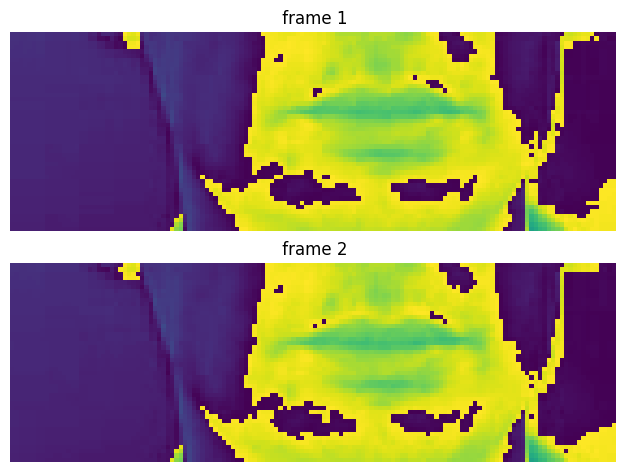

In [99]:
#plotting one frame
for i in range(1,3):
    plt.subplot(2,1, i)
    plt.imshow(frames[i])
    plt.title(f" frame {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [100]:
num_2_char(alignment.numpy())

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [101]:
[x.decode('utf-8') for x in num_2_char(alignment.numpy()).numpy()]

['b',
 'i',
 'n',
 ' ',
 'b',
 'l',
 'u',
 'e',
 ' ',
 'a',
 't',
 ' ',
 'l',
 ' ',
 's',
 'i',
 'x',
 ' ',
 'n',
 'o',
 'w']

In [102]:
print([bytes.decode(x) for x in num_2_char(alignment.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [103]:
tf.strings.reduce_join([bytes.decode(x) for x in num_2_char(alignment.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
# function to mapp and create a data pipeline
def mapp_func(path):
    res = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return res